# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [16]:
dto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c' #  Directory to Open
dto = '/storage/experiments/2021/0609_bourka_sobeslav/GEODOS/BF'
#dto = '/storage/experiments/2021/0605_bourka_radosovice/GEODOS/BF'
dto = '/storage/experiments/2021/0803_bourka_votice/geodos'
dto = '/storage/stations/Polednik/geodos/2021/10/10'
#dto = '/storage/stations/Polednik/geodos/2021/10/13'
#dto = '/storage/stations/Polednik/geodos/2021/10/EC'
dto = '/storage/stations/Polednik/geodos/2021/08/10/210812'
dto = '/storage/stations/Polednik/geodos/2021/08/13/210720'
dto = '/storage/experiments/2022/0714_bourka_horovice_CAR1/geodos'
dto = '/storage/stations/Polednik/geodos/2022/07/chlum'
dto = '/storage/stations/Polednik/geodos/2022/06/EC_vez'
dto = '/storage/stations/Kosetice/GEODOS'

#fto = dto + '/DATALOG.TXT'
fto = dto + '/0.TXT'

l=[]
l.extend(range(0,300))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a200921812a000a0000045
f.v.:  NaI(Tl)-D18x30
0         GEO_1024_v4
1         GEO_1024_v4
12        GEO_1024_v4
106224    GEO_1024_v4
212436    GEO_1024_v4
Name: 1, dtype: object
318550
212436


## Fill position and time

In [14]:
break

#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,alt,lat,lon,meas,UTC,flag,on_miliseconds
2,$HIST,0,22.87,937.94,19.31,2.70,-21,90,0,34216,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaT,False,NaN
3,$HITS,47,2731,35,3001,87,3050,111,3809,64,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaT,False,NaN
4,$HIST,1,35.68,937.94,19.31,2.70,-24,180,0,34195,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,False,NaN
5,$HITS,32,1921,47,3613,34,3779,170,4816,39,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,False,NaN
6,$HIST,2,48.47,937.94,19.31,2.70,-25,254,1,34220,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaT,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318641,$HITS,7,1505,539,16660,110,22463,204,43327,797,...,NaN,NaN,NaN,NaN,NaN,NaN,52998,NaT,False,NaN
318642,$HIST,52999,694680.80,944.45,-1.88,2.74,-13,2917,0,34348,...,NaN,NaN,NaN,NaN,NaN,NaN,52999,NaT,False,NaN
318643,$HITS,7,11244,70,15763,30,25020,47,51516,52,...,NaN,NaN,NaN,NaN,NaN,NaN,52999,NaT,False,NaN
318644,$HIST,53000,694704.80,944.47,-1.88,2.74,-14,10,1,34347,...,NaN,NaN,NaN,NaN,NaN,NaN,53000,NaT,False,NaN


## Galileo support

In [17]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,299,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
2,$HIST,0,22.87,937.94,19.31,2.70,-21,90,0,34216,...,NaN,False,NaN,22870.0,NaN,NaN,NaN,NaT,2,NaT
3,$HITS,47,2731,35,3001,87,3050,111,3809,64,...,NaN,False,NaN,22870.0,NaN,NaN,NaN,NaT,2,NaT
4,$HIST,1,35.68,937.94,19.31,2.70,-24,180,0,34195,...,NaN,False,NaN,35680.0,NaN,NaN,NaN,NaT,4,NaT
5,$HITS,32,1921,47,3613,34,3779,170,4816,39,...,NaN,False,NaN,35680.0,NaN,NaN,NaN,NaT,4,NaT
6,$HIST,2,48.47,937.94,19.31,2.70,-25,254,1,34220,...,NaN,False,NaN,48470.0,NaN,NaN,NaN,NaT,6,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318641,$HITS,7,1505,539,16660,110,22463,204,43327,797,...,NaN,False,652544540.0,694667680.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318640,2023-02-10 15:35:44.140
318642,$HIST,52999,694680.80,944.45,-1.88,2.74,-13,2917,0,34348,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318643,$HITS,7,11244,70,15763,30,25020,47,51516,52,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318644,$HIST,53000,694704.80,944.47,-1.88,2.74,-14,10,1,34347,...,NaN,False,652544540.0,694704800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318644,2023-02-10 15:36:21.260


In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,299,alt,lat,lon,meas,UTC,flag,on_miliseconds,miliseconds,date
2,$HIST,0,22.87,937.94,19.31,2.70,-21,90,0,34216,...,NaN,NaN,NaN,NaN,2,NaT,False,NaN,22870.0,NaT
3,$HITS,47,2731,35,3001,87,3050,111,3809,64,...,NaN,NaN,NaN,NaN,2,NaT,False,NaN,22870.0,NaT
4,$HIST,1,35.68,937.94,19.31,2.70,-24,180,0,34195,...,NaN,NaN,NaN,NaN,4,NaT,False,NaN,35680.0,NaT
5,$HITS,32,1921,47,3613,34,3779,170,4816,39,...,NaN,NaN,NaN,NaN,4,NaT,False,NaN,35680.0,NaT
6,$HIST,2,48.47,937.94,19.31,2.70,-25,254,1,34220,...,NaN,NaN,NaN,NaN,6,NaT,False,NaN,48470.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318641,$HITS,7,1505,539,16660,110,22463,204,43327,797,...,NaN,762.1,49.572439,15.080041,318640,NaT,False,NaN,694667680.0,2023-02-10 03:53:41
318642,$HIST,52999,694680.80,944.45,-1.88,2.74,-13,2917,0,34348,...,NaN,762.1,49.572439,15.080041,318642,NaT,False,NaN,694680800.0,2023-02-10 03:53:41
318643,$HITS,7,11244,70,15763,30,25020,47,51516,52,...,NaN,762.1,49.572439,15.080041,318642,NaT,False,NaN,694680800.0,2023-02-10 03:53:41
318644,$HIST,53000,694704.80,944.47,-1.88,2.74,-14,10,1,34347,...,NaN,762.1,49.572439,15.080041,318644,NaT,False,NaN,694704800.0,2023-02-10 03:53:41


## Add individual events to histogram

In [18]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:20].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [19]:
hits.iloc[:,40:300] = 0
for i in range(len(hits)):
    for j in range(hits.iloc[i,1]):
        hits.iloc[i,int(40+hits.iloc[i,j*2+3])] +=1
#hits.merge(hist)
#hits.drop(hits.iloc[:,18:40], axis=1, inplace=True)
histogram = pd.DataFrame()
histogram = hist.iloc[:,11:18]
histogram = histogram.join(hits.iloc[:,40+11:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:258],range(0,258))})
histogram

IndexError: index 880 is out of bounds for axis 0 with size 308

In [27]:
histogram.iloc[:,:25]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
meas,,,,,,,,,,,,,,,,,,,,,
22,29615.0,4219,489,10.0,8.0,10.0,12.0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
24,29674.0,4094,546,11.0,5.0,9.0,6.0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
26,29869.0,3887,562,12.0,9.0,12.0,8.0,0,0,0,...,0,0,0,0,0,0,0,1,2,0
28,29705.0,4045,561,15.0,11.0,12.0,9.0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
30,29735.0,4030,566,10.0,8.0,11.0,8.0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,30020.0,3143,979,23.0,12.0,25.0,15.0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
5968,30070.0,3148,967,21.0,20.0,22.0,9.0,0,0,0,...,0,0,0,0,0,0,0,2,2,1
5970,30018.0,3237,993,18.0,12.0,12.0,11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Plot Flux

/tmp/ipykernel_6138/1155876177.py:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc['2021-11-4 00:00:00':'2021-11-5 00:00:00'] # FD 11. 2021
/tmp/ipykernel_6138/1155876177.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_6138/1155876177.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


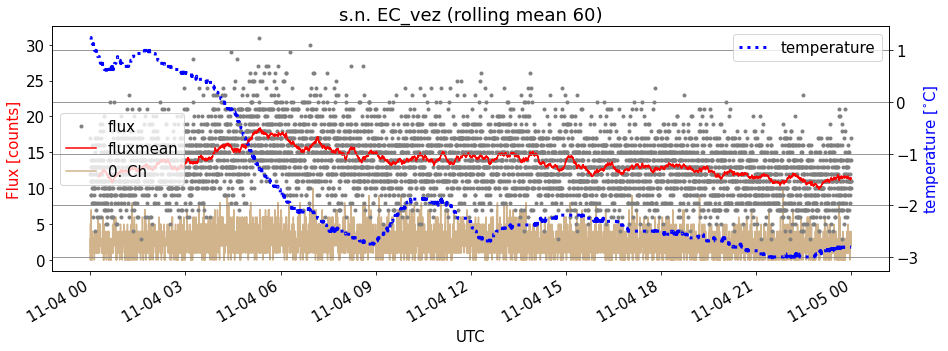

In [14]:
NOISE_LEVEL = 0
LAST_CHANNEL = 256
WINDOW = 60

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenu dobijeci eletronikou
xx = xx.loc['2021-11-4 00:00:00':'2021-11-5 00:00:00'] # FD 11. 2021


#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_21264/1363537573.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_21264/1363537573.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


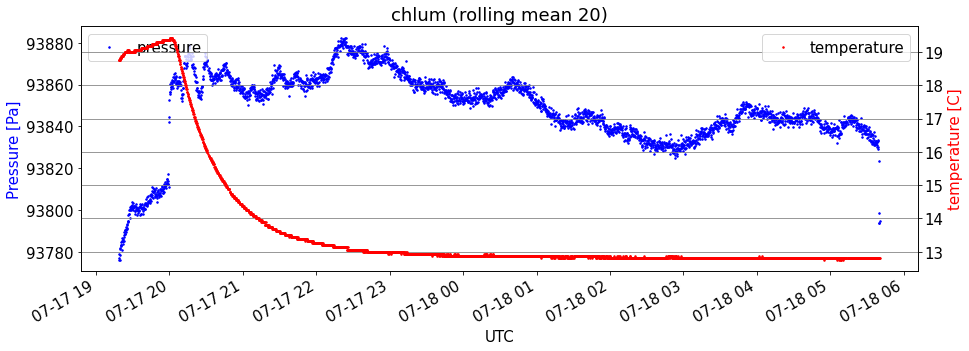

In [15]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



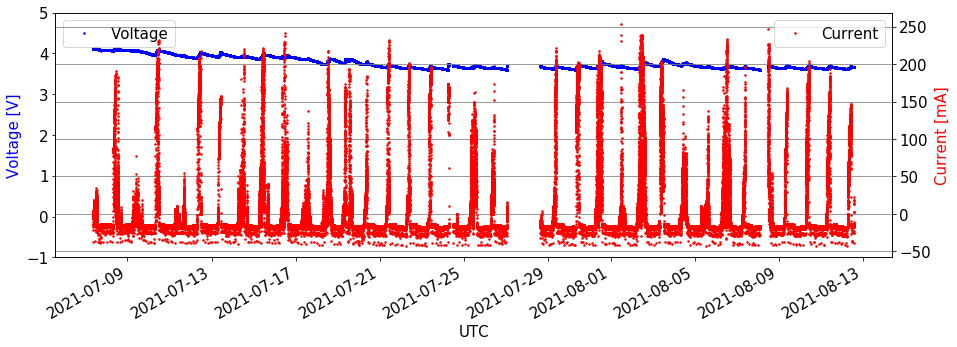

In [28]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



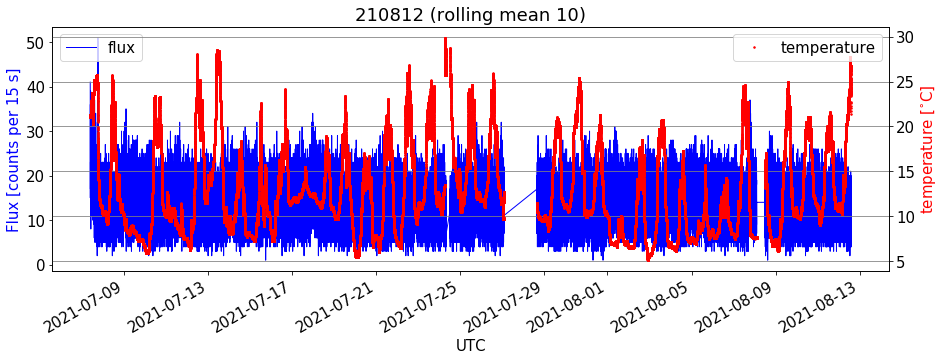

In [22]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [15]:
lat=49.0640992 # Polednik
lon=13.3950208

#lat=49.05367 # Prvni strom
#lon=13.40039

#start=pd.Timestamp('2021-08-15 12:00') # bourke kdy odesla dobijeci elektronika
#end=pd.Timestamp('2021-08-16 18:00')

start=pd.Timestamp('2021-07-08 00:00') # bourka kdy odesla dobijeci elektronika
end=pd.Timestamp('2021-08-13 00:00')

BLITZ_DIST = 60

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig','mds','mcg'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2021-07-08 00:00:00 2021-08-13 00:00:00 49.0640992 13.3950208
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/21/00.json
No data http:/

In [16]:
blitz

,time,lat,lon,km,date
date,,,,,
2021-07-08 00:48:30.829185439,1625705310829185439,48.632866,13.240356,49.322458,2021-07-08 00:48:30.829185439
2021-07-08 00:48:30.831775957,1625705310831775957,48.653590,13.260290,46.749865,2021-07-08 00:48:30.831775957
2021-07-08 00:48:30.831781386,1625705310831781386,48.652350,13.263133,46.841445,2021-07-08 00:48:30.831781386
2021-07-08 00:48:30.831782609,1625705310831782609,48.643393,13.253908,47.958762,2021-07-08 00:48:30.831782609
2021-07-08 11:56:00.228902204,1625745360228902204,48.957762,12.619286,57.863355,2021-07-08 11:56:00.228902204
...,...,...,...,...,...
2021-08-08 14:43:05.345944478,1628433785345944478,49.431200,13.125008,45.330898,2021-08-08 14:43:05.345944478
2021-08-08 14:43:05.345913004,1628433785345913004,49.539735,13.026111,59.332627,2021-08-08 14:43:05.345913004
2021-08-08 14:43:05.345945476,1628433785345945476,49.439992,13.117333,46.453850,2021-08-08 14:43:05.345945476


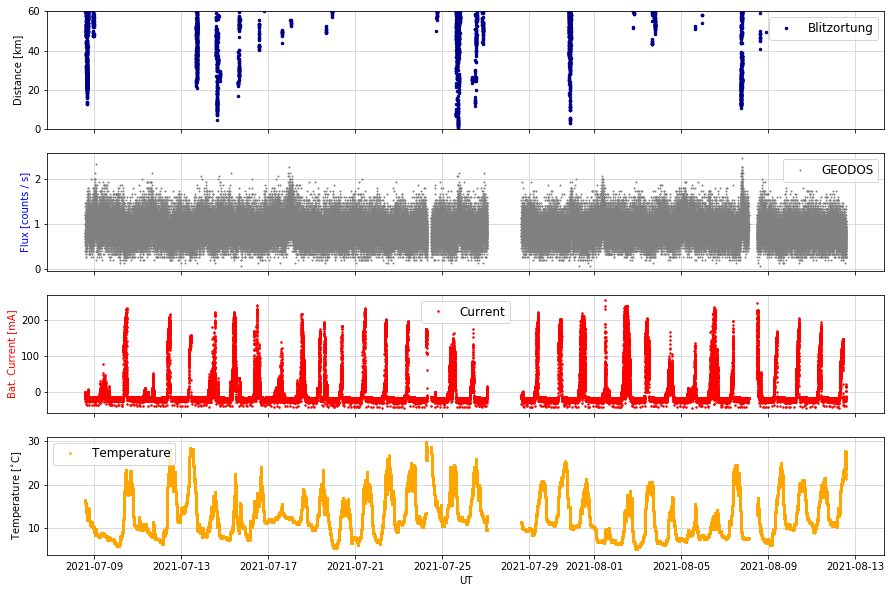

In [30]:
WINDOW = 2

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 14:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-08-15 12:00:00'
#TO = '2021-08-16 18:00:00'
#FROM = '2021-08-15 18:00:00'
#TO = '2021-08-15 19:00:00'
#FROM = '2021-08-16 9:00:00'
#TO = '2021-08-16 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-15 19:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-16 9:00:00':'2021-08-16 12:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-16 18:15:00']



xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
#ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
#ax3.set_yscale('log')
#ax3.set_ylim(.6,2.5)
ax3.legend(loc=1)


ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


In [20]:
xx

,0,1,2,3,4,5,6,7,8,9,...,lat,lon,date,UTC,temperature,pressure,voltage,current,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-08-15 18:00:06.550,2.0,3,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:06.550,16.94,86737.50,4.08,-65,12.0,NaN
2021-08-15 18:00:22.420,5.0,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:22.420,16.88,86747.50,4.08,-65,14.0,13.0
2021-08-15 18:00:38.600,4.0,4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:38.600,16.88,86737.75,4.08,-65,15.0,14.5
2021-08-15 18:00:54.770,2.0,1,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:54.770,16.81,86754.75,4.08,-65,10.0,12.5
2021-08-15 18:01:10.960,1.0,3,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:01:10.960,16.81,86747.50,4.08,-65,11.0,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-15 18:58:48.140,3.0,3,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:58:48.140,15.81,86661.75,-0.26,-257,20.0,16.0
2021-08-15 18:59:04.300,3.0,2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:04.300,15.81,86654.75,-0.26,-257,14.0,17.0
2021-08-15 18:59:20.470,3.0,6,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:20.470,15.88,86653.00,-0.26,-257,17.0,15.5


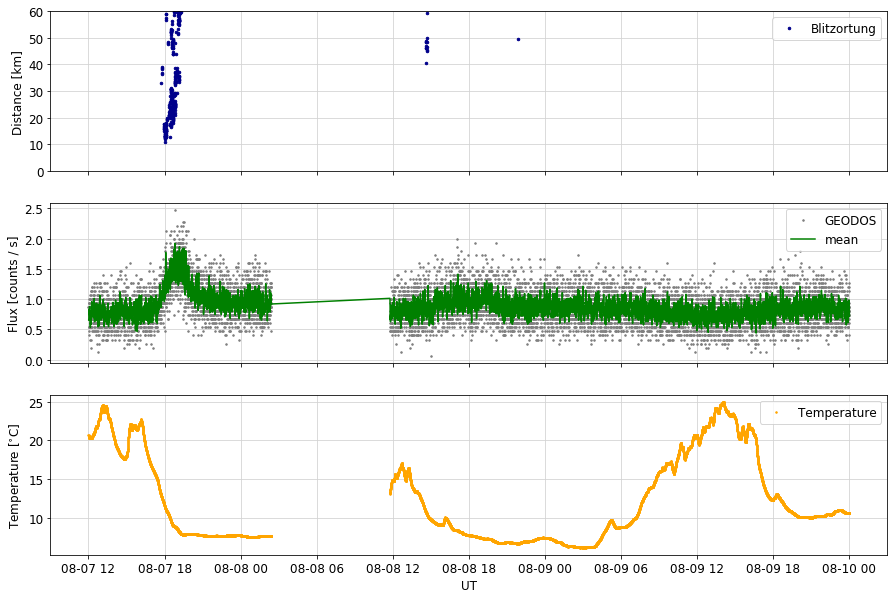

In [72]:
WINDOW = 5

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 12:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-07-30 12:00:00'
#TO = '2021-08-2 12:00:00'
FROM = '2021-08-7 12:00:00'
TO = '2021-08-10 00:00:00'
#FROM = '2021-07-25 12:00:00'
#TO = '2021-07-26 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=3, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean', color='green')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]')
#ax3.set_yscale('log')
#ax3.set_ylim(.5,2.2)
ax3.legend()
#ax3.set_xlabel('UT')

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

/tmp/ipykernel_6138/949728858.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2021-11-3 00:00:00':'2021-11-3 12:00:00'] # FD 11. 2021
/tmp/ipykernel_6138/949728858.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ener = yy.iloc[:,0:1000].sum()


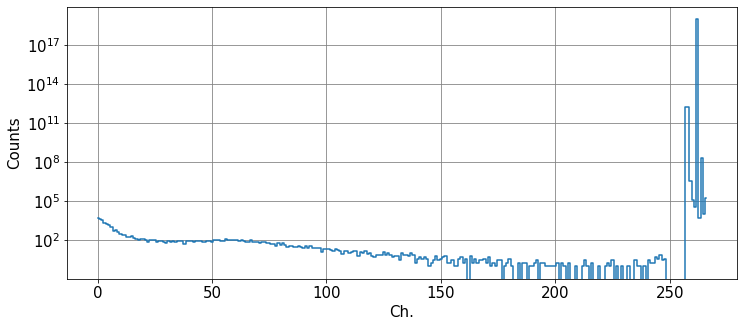

In [17]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-4 00:00:00':'2021-11-4 12:00:00'] # FD 11. 2021
yy = yy.loc['2021-11-3 00:00:00':'2021-11-3 12:00:00'] # FD 11. 2021

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:1000].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

/tmp/ipykernel_6138/1968384001.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2021-11-4 00:00:00':'2021-11-4 12:00:00'] # FD 11. 2021
/tmp/ipykernel_6138/1968384001.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ener = yy.iloc[:,0:1000].sum()
/tmp/ipykernel_6138/1968384001.py:24: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2021-11-3 00:00:00':'2021-11-3 12:00:00'] # FD 11. 2021
/tmp/ipykernel_6138/1968384001.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will r

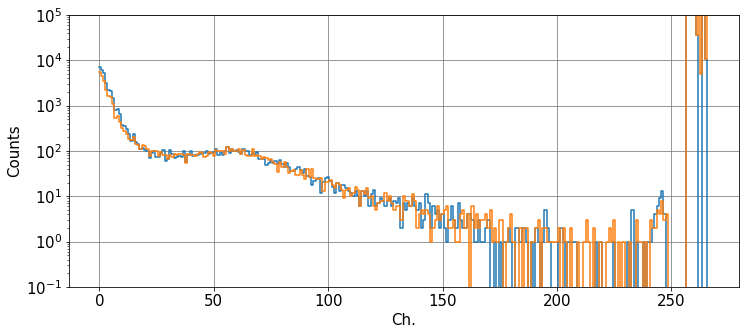

In [21]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
yy = yy.loc['2021-11-4 00:00:00':'2021-11-4 12:00:00'] # FD 11. 2021

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:1000].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.ylim([0.1,1e5])

yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-4 00:00:00':'2021-11-4 12:00:00'] # FD 11. 2021
yy = yy.loc['2021-11-3 00:00:00':'2021-11-3 12:00:00'] # FD 11. 2021

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:1000].sum()
ener = ener.reset_index()
#plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

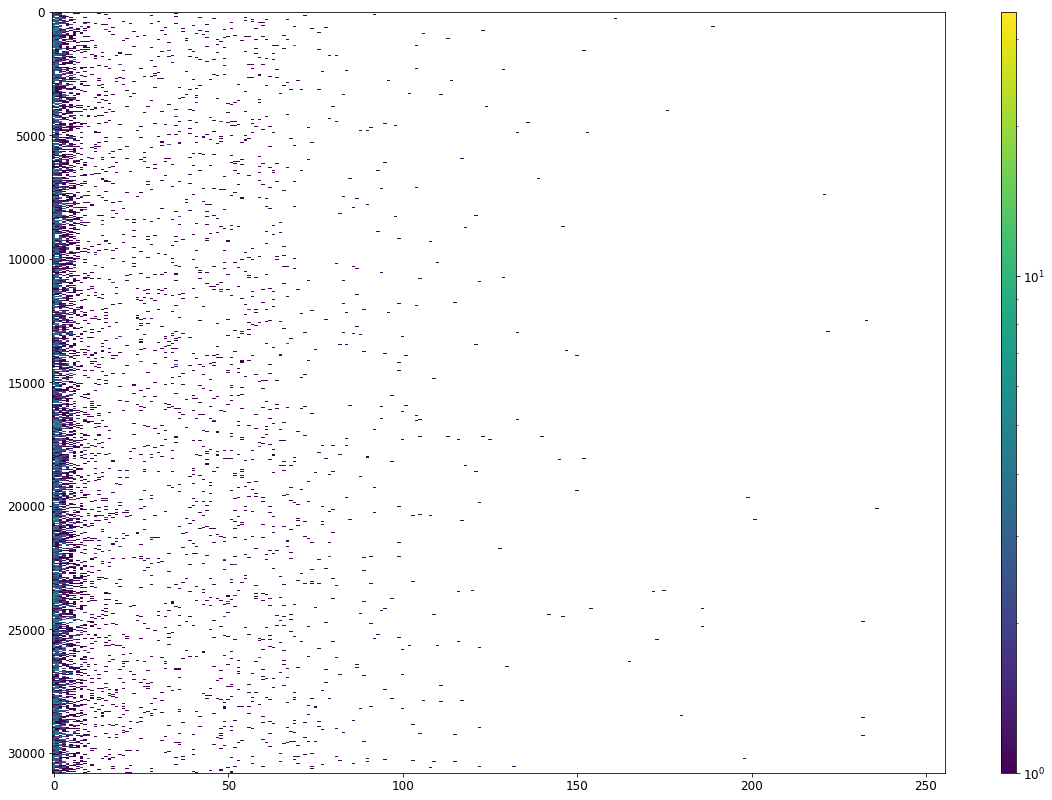

In [33]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None